# Using vireo for multiplexing, followed by lineage tracing of those groups

# 1. Set up

In [1]:
import os
os.chdir("/data2/mito_lineage/")#Analysis/multiplex")

In [2]:
# papermill --cwd /data2/mito_lineage -p INDIR {INDIR} -p OUTDIR data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/clones -p  src/vireo/2_MT_Lineage_Construct.ipynb 

In [3]:
pwd

'/data2/mito_lineage'

### Remove this when running in snakemake

## 1.1 Parameters

In [1]:
# INDIR=""
# OUTDIR=""
# N_DONORS=5

# INDIR= "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex"
# OUTDIR= "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/clones/"
# N_DONORS=2
DEBUG=True

INDIR= "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex"
OUTDIR = "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/clones"
N_DONORS=2

n_clone_list="20,40,100"#[20, 40, 100]

In [2]:
n_clone_list = [int(x) for x in n_clone_list.split(",")]
n_clone_list

[20, 40, 100]

In [5]:
# # Parameters
# #INDIR="data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/"
# INDIR=""
# OUTDIR=""
# #OUTDIR="data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.0001/numC25000_ispropFalse/lineages"
# N_DONORS=5

## 1.2 Import packages

In [6]:
from os.path import join, exists, dirname
from icecream import ic
from glob import glob
import mplh.cluster_help as ch
import os
from vireoSNP.plot.base_plot import heat_matrix
from vireoSNP import Vireo
import src.pseudo_batch as pb
import vireoSNP
ic(vireoSNP.__version__)
from tqdm import tqdm
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.vireo.vireo_utils import run_vireo, plot_vireo_out, extract_clusters, run_elbo, separate_donors
%load_ext autoreload
%autoreload 2
from src.vireo.vireo_utils import run_lineage
#np.set_icoptions(formatter={'float': lambda x: format(x, '.5f')})

ic| vireoSNP.__version__: '0.5.6'


In [7]:
if not DEBUG:
    ic.disable()


# 2 Lineage construction for each donor

In [8]:
# num_cores = 12# N_DONORS #multiprocessing.cpu_count()
# inputs = tqdm(np.arange(N_DONORS))
# for n in np.arange(N_DONORS):
#     ic('n', n)
#     run_lineage(n, INDIR, OUTDIR, n_clone_list=[5, 10, 20, 40, 100], rerun_model=False)

In [10]:
cells_meta = pd.read_csv(join(INDIR, f"cells_meta.tsv"), sep='\t')

cells_meta=cells_meta.astype({"donor_index": "Int64", "donor": "Int64"})
cells_meta

,new index,ID,raw ID,condition,donor,donor_index
0,1,AAACGAAAGCCGCAAA-1_pre,AAACGAAAGCCGCAAA-1,pre,1,1
1,2,AAACGAAAGGCTCCTG-1_pre,AAACGAAAGGCTCCTG-1,pre,0,1
2,3,AAACGAAAGTAGCAAT-1_pre,AAACGAAAGTAGCAAT-1,pre,1,2
3,4,AAACGAAAGTGAATAC-1_pre,AAACGAAAGTGAATAC-1,pre,0,2
4,5,AAACGAAAGTGTCACT-1_pre,AAACGAAAGTGTCACT-1,pre,0,3
...,...,...,...,...,...,...
15584,15585,TTTGTGTTCCGGAAAG-1_post,TTTGTGTTCCGGAAAG-1,post,1,8015
15585,15586,TTTGTGTTCCTGACCT-1_post,TTTGTGTTCCTGACCT-1,post,1,8016
15586,15587,TTTGTGTTCGGATGTT-1_post,TTTGTGTTCGGATGTT-1,post,0,6744
15587,15588,TTTGTGTTCTTAATCC-1_post,TTTGTGTTCTTAATCC-1,post,1,8017


/data/isshamie/software/anaconda3/envs/mito_trace/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='donor', ylabel='count'>

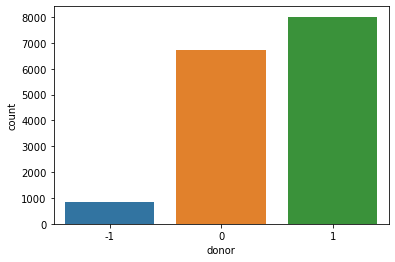

In [11]:
sns.countplot(cells_meta["donor"].fillna(-1))

In [12]:
def run_lineage_wrap(indir, outdir, n_donors, n_clone_list, cells_meta):
    for clone in n_clone_list:
        cells_meta_col = f"lineage{clone}"
        curr_outdir = join(outdir, cells_meta_col)
        if not exists(curr_outdir):
            os.mkdir(curr_outdir)
        curr_cells_meta = cells_meta.copy()
        all_cells_meta = [] #concat across donors
        
        for donor in np.arange(n_donors):
            print(f'clone: {n_clone_list} donor: {donor}')
            curr_ad_f = join(indir, f"donor{donor}.AD.mtx")
            curr_dp_f = join(indir, f"donor{donor}.DP.mtx")
            curr_labels_f = join(indir, f"donor{donor}.labels.txt")
            curr_vcf_f = join(indir, f"donor{donor}.vcf")
            curr_labels_rawID = join(indir, f"cell_labels.donor{donor}.txt")
            prefix=f"donor{donor}_"
            
            ic(curr_ad_f)
            ic(curr_dp_f)
            if not ((cells_meta["donor"] == donor).any()):
                print(f"Donor {donor} is empty. Continuing")
                continue
            curr_ad = mmread(curr_ad_f).tocsc()
            curr_dp = mmread(curr_dp_f).tocsc()
            curr_labels = pd.read_csv(curr_labels_f, index_col=0)
            
            curr_vcf = pd.read_csv(curr_vcf_f, sep='\t')
            ic('curr_vcf')
            ic(curr_vcf.head())
            #curr_cells_meta = pd.read_csv(curr_labels_rawID, index_col=0)
#             ic('curr_labels')
#             ic(curr_labels.head())
            prefix = f"donor{donor}_"
            model_name = f"{prefix}lineage_{clone}"
            modelCA, elbo = run_vireo(curr_ad, curr_dp, clone, n_cores=32, plot_qc=True,out_f=join(curr_outdir, model_name))
            try:
                doublet_prob = modelCA.predict_doublet(curr_ad, curr_dp, update_GT=False, update_ID=False)[0].sum(axis=1)
            except AttributeError: # New version of Vireo 2021
                #doublet_prob = vireoSNP.utils.vireo_doublet.predict_doublet(modelCA,AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)
                doublet_prob = vireoSNP.utils.vireo_doublet.predict_doublet(modelCA, curr_ad, curr_dp, update_GT=False, update_ID=False)[0].sum(axis=1)

            separate_donors(curr_ad, curr_dp, modelCA, curr_cells_meta, curr_outdir,
                            doublet_prob,
                            prob_thresh=0.9, doublet_thresh=0.9,
                            cells_ind_col='donor_index',
                            out_name="lineage", prefix=prefix, cells_filt_col="donor", 
                            cells_filt_val=donor, vars_meta=curr_vcf)    
            
            lin_cells_meta = pd.read_csv(join(curr_outdir, f"{prefix}cells_meta.tsv"), sep='\t')
            ic(lin_cells_meta.head())
            ic(lin_cells_meta.shape)
            all_cells_meta.append(lin_cells_meta)
            ic("Plotting AF SNPs")
            lin_cells_meta = lin_cells_meta.astype({"lineage": 'Int64'}).fillna(-1).astype(str)
            plot_vireo_out(modelCA, out_f=join(curr_outdir, model_name+"OUT"), 
                           labels=lin_cells_meta[["condition", "lineage"]], 
                           doublet_prob=doublet_prob)

            plt.close()
            
        # Concat cells_meta across donors
        all_cells_meta = pd.concat(all_cells_meta, axis=0)
        all_cells_meta = all_cells_meta.astype({"lineage_index": "Int64", "lineage": "Int64"})
        ic(all_cells_meta.head())
        ic(all_cells_meta.shape)
        all_cells_meta.to_csv(join(curr_outdir, "cells_meta.tsv"), sep='\t')
    return

ic| curr_ad_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor0.AD.mtx'
ic| curr_dp_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor0.DP.mtx'


clone: [20, 40, 100] donor: 0


ic| 'curr_vcf'
ic| curr_vcf.head():   index_x #CHROM    POS     REF ALT  strand_correlation_x     vmr_x  \
                     0     NaN   chrM  16390  16390G   A                   NaN       NaN   
                     1   49A>G   chrM     49     49A   G              0.953444  0.030571   
                     2   49A>C   chrM     49     49A   C              0.745356  0.012609   
                     3   57T>A   chrM     57     57T   A              1.000000  0.019802   
                     4   57T>G   chrM     57     57T   G              1.000000  0.028867   
                     
                        n_cells_over_5_x  n_cells_over_20_x  \
                     0               NaN                NaN   
                     1              28.0                0.0   
                     2               0.0                0.0   
                     3               0.0                0.0   
                     4               1.0                0.0   
                     
           

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

positions to use
[   0    1    2 ... 1221 1222 1223]
lineage 6: 392 cells 
(21485, 3)
(21485, 3)
donor0_lineage6
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 21

donor0_lineage9
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 2

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

ic| 'Plotting AF SNPs'


cell meta
             new index                      ID              raw ID condition  \
donor_index                                                                    
1                    2  AAACGAAAGGCTCCTG-1_pre  AAACGAAAGGCTCCTG-1       pre   
2                    4  AAACGAAAGTGAATAC-1_pre  AAACGAAAGTGAATAC-1       pre   
3                    5  AAACGAAAGTGTCACT-1_pre  AAACGAAAGTGTCACT-1       pre   
4                    7  AAACGAACATAGGCGA-1_pre  AAACGAACATAGGCGA-1       pre   
5                    9  AAACGAAGTTAACTCG-1_pre  AAACGAAGTTAACTCG-1       pre   

             donor  lineage  lineage_index  
donor_index                                 
1                0       14              1  
2                0        1              1  
3                0        1              2  
4                0     <NA>           <NA>  
5                0     <NA>           <NA>  
rand_df (1000, 21)
              AF 1          AF 2          AF 3          AF 4          AF 5  \
4859  5.282920e-0

ic| curr_ad_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor1.AD.mtx'
ic| curr_dp_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor1.DP.mtx'


clone: [20, 40, 100] donor: 1


ic| 'curr_vcf'
ic| curr_vcf.head():   index_x #CHROM    POS     REF ALT  strand_correlation_x     vmr_x  \
                     0     NaN   chrM  16390  16390G   A                   NaN       NaN   
                     1   49A>G   chrM     49     49A   G              0.953444  0.030571   
                     2   49A>C   chrM     49     49A   C              0.745356  0.012609   
                     3   57T>A   chrM     57     57T   A              1.000000  0.019802   
                     4   57T>G   chrM     57     57T   G              1.000000  0.028867   
                     
                        n_cells_over_5_x  n_cells_over_20_x  \
                     0               NaN                NaN   
                     1              28.0                0.0   
                     2               0.0                0.0   
                     3               0.0                0.0   
                     4               1.0                0.0   
                     
           

positions to use
[   0    1    2 ... 1120 1121 1122]
lineage 0: 402 cells 
(15155, 3)
(15155, 3)
donor1_lineage0
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 21

donor1_lineage3
positions to use
[   0    1    2 ... 1193 1194 1195]
lineage 4: 211 cells 
(14325, 3)
(14325, 3)
donor1_lineage4
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 21

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

positions to use
[   0    1    2 ... 1046 1047 1048]
lineage 16: 584 cells 
(17270, 3)
(17270, 3)
donor1_lineage16
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 

ic| 'Plotting AF SNPs'


rand_df (1000, 21)
              AF 1          AF 2          AF 3          AF 4          AF 5  \
6733  1.420708e-07  9.999983e-01  3.080794e-07  2.532708e-07  2.315972e-06   
4003  1.463030e-07  2.771582e-07  2.725362e-01  3.621171e-08  2.725363e-01   
4040  1.045449e-01  1.826997e-07  2.176413e-01  4.965051e-07  2.176417e-01   
3888  4.825313e-08  9.617671e-03  1.251287e-07  1.181289e-07  4.185034e-07   
3910  4.061670e-01  4.326552e-06  1.781006e-07  1.508197e-07  3.751884e-03   

              AF 6          AF 7          AF 8          AF 9         AF 10  \
6733  6.141303e-08  2.554431e-07  1.212462e-07  1.218300e-07  2.115403e-07   
4003  1.009573e-07  2.961892e-07  4.803401e-07  2.204764e-07  4.329110e-01   
4040  7.836948e-08  3.961340e-07  2.010064e-06  4.107635e-05  6.692313e-02   
3888  9.578844e-03  2.856269e-04  3.277892e-02  4.335890e-01  2.554219e-07   
3910  4.720961e-07  4.707931e-07  4.741539e-07  1.093841e-07  5.049553e-01   

      ...         AF 12         AF 13      

ic| all_cells_meta.head():    donor_index  new index                      ID              raw ID  \
                           0            1          2  AAACGAAAGGCTCCTG-1_pre  AAACGAAAGGCTCCTG-1   
                           1            2          4  AAACGAAAGTGAATAC-1_pre  AAACGAAAGTGAATAC-1   
                           2            3          5  AAACGAAAGTGTCACT-1_pre  AAACGAAAGTGTCACT-1   
                           3            4          7  AAACGAACATAGGCGA-1_pre  AAACGAACATAGGCGA-1   
                           4            5          9  AAACGAAGTTAACTCG-1_pre  AAACGAAGTTAACTCG-1   
                           
                             condition  donor  lineage  lineage_index  
                           0       pre      0        8              1  
                           1       pre      0        8              2  
                           2       pre      0       12              1  
                           3       pre      0     <NA>           <NA>  
            

clone: [20, 40, 100] donor: 0


ic| 'curr_vcf'
ic| curr_vcf.head():   index_x #CHROM    POS     REF ALT  strand_correlation_x     vmr_x  \
                     0     NaN   chrM  16390  16390G   A                   NaN       NaN   
                     1   49A>G   chrM     49     49A   G              0.953444  0.030571   
                     2   49A>C   chrM     49     49A   C              0.745356  0.012609   
                     3   57T>A   chrM     57     57T   A              1.000000  0.019802   
                     4   57T>G   chrM     57     57T   G              1.000000  0.028867   
                     
                        n_cells_over_5_x  n_cells_over_20_x  \
                     0               NaN                NaN   
                     1              28.0                0.0   
                     2               0.0                0.0   
                     3               0.0                0.0   
                     4               1.0                0.0   
                     
           

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209]
lineage 5: 16 cells 
(424, 3)
(424, 3)
donor0_lineage5
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

ic| 'Plotting AF SNPs'


rand_df (1000, 41)
              AF 1          AF 2          AF 3          AF 4          AF 5  \
5983  3.220698e-07  1.001816e-06  4.064340e-07  3.746926e-05  7.218666e-07   
5013  9.952786e-01  1.128895e-06  1.820163e-07  3.209496e-07  4.001912e-07   
55    5.092885e-03  9.774423e-09  2.676725e-07  5.823959e-08  2.487224e-07   
2702  9.943294e-08  3.276288e-07  3.312887e-07  2.005849e-07  9.999174e-01   
4515  3.380524e-08  1.744957e-07  3.202108e-10  4.415994e-07  4.247314e-07   

              AF 6          AF 7          AF 8          AF 9         AF 10  \
5983  4.984372e-07  2.095504e-08  2.773424e-07  4.530057e-07  8.848825e-08   
5013  3.524820e-07  1.813735e-07  4.014878e-07  4.804384e-08  5.200539e-06   
55    4.128853e-08  8.387872e-08  3.362916e-07  9.048020e-08  1.283555e-01   
2702  4.429246e-08  3.159836e-07  2.546947e-07  8.325422e-05  3.235368e-07   
4515  2.667922e-07  4.550590e-07  3.383116e-07  4.948777e-07  2.933457e-07   

      ...         AF 32         AF 33      

ic| curr_ad_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor1.AD.mtx'
ic| curr_dp_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor1.DP.mtx'


clone: [20, 40, 100] donor: 1


ic| 'curr_vcf'
ic| curr_vcf.head():   index_x #CHROM    POS     REF ALT  strand_correlation_x     vmr_x  \
                     0     NaN   chrM  16390  16390G   A                   NaN       NaN   
                     1   49A>G   chrM     49     49A   G              0.953444  0.030571   
                     2   49A>C   chrM     49     49A   C              0.745356  0.012609   
                     3   57T>A   chrM     57     57T   A              1.000000  0.019802   
                     4   57T>G   chrM     57     57T   G              1.000000  0.028867   
                     
                        n_cells_over_5_x  n_cells_over_20_x  \
                     0               NaN                NaN   
                     1              28.0                0.0   
                     2               0.0                0.0   
                     3               0.0                0.0   
                     4               1.0                0.0   
                     
           

positions to use
[   0    1    2 ... 1215 1216 1217]
lineage 0: 299 cells 
(17781, 3)
(17781, 3)
donor1_lineage0
positions to use
[   0    1    2 ... 1130 1131 1132]
lineage 1: 209 cells 
(10934, 3)
(10934, 3)
donor1_lineage1
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177]
lineage 2: 11 cells 
(357, 3)
(357

donor1_lineage10
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225]
lineage 11: 17 cells 
(524, 3)
(524, 3)
donor1_l

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

donor1_lineage25
positions to use
[   0    1    2 ... 1046 1047 1048]
lineage 26: 396 cells 
(12914, 3)
(12914, 3)
donor1_lineage26
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

donor1_lineage36
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223]
lineage 37: 17 cells 
(535, 3)
(535, 3)
donor1_lineage37

ic| 'Plotting AF SNPs'


cell meta
             new index                      ID              raw ID condition  \
donor_index                                                                    
1                    1  AAACGAAAGCCGCAAA-1_pre  AAACGAAAGCCGCAAA-1       pre   
2                    3  AAACGAAAGTAGCAAT-1_pre  AAACGAAAGTAGCAAT-1       pre   
3                    6  AAACGAACACGGCCAT-1_pre  AAACGAACACGGCCAT-1       pre   
4                    8  AAACGAACATTAACGC-1_pre  AAACGAACATTAACGC-1       pre   
5                   10  AAACGAAGTTTAAGGA-1_pre  AAACGAAGTTTAAGGA-1       pre   

             donor  lineage  lineage_index  
donor_index                                 
1                1     <NA>           <NA>  
2                1     <NA>           <NA>  
3                1       33              1  
4                1       26              1  
5                1     <NA>           <NA>  
rand_df (1000, 41)
          AF 1          AF 2          AF 3          AF 4          AF 5  \
6245  0.041661  8.161

ic| all_cells_meta.head():    donor_index  new index                      ID              raw ID  \
                           0            1          2  AAACGAAAGGCTCCTG-1_pre  AAACGAAAGGCTCCTG-1   
                           1            2          4  AAACGAAAGTGAATAC-1_pre  AAACGAAAGTGAATAC-1   
                           2            3          5  AAACGAAAGTGTCACT-1_pre  AAACGAAAGTGTCACT-1   
                           3            4          7  AAACGAACATAGGCGA-1_pre  AAACGAACATAGGCGA-1   
                           4            5          9  AAACGAAGTTAACTCG-1_pre  AAACGAAGTTAACTCG-1   
                           
                             condition  donor  lineage  lineage_index  
                           0       pre      0       22              1  
                           1       pre      0       28              1  
                           2       pre      0       16              1  
                           3       pre      0     <NA>           <NA>  
            

clone: [20, 40, 100] donor: 0


ic| 'curr_vcf'
ic| curr_vcf.head():   index_x #CHROM    POS     REF ALT  strand_correlation_x     vmr_x  \
                     0     NaN   chrM  16390  16390G   A                   NaN       NaN   
                     1   49A>G   chrM     49     49A   G              0.953444  0.030571   
                     2   49A>C   chrM     49     49A   C              0.745356  0.012609   
                     3   57T>A   chrM     57     57T   A              1.000000  0.019802   
                     4   57T>G   chrM     57     57T   G              1.000000  0.028867   
                     
                        n_cells_over_5_x  n_cells_over_20_x  \
                     0               NaN                NaN   
                     1              28.0                0.0   
                     2               0.0                0.0   
                     3               0.0                0.0   
                     4               1.0                0.0   
                     
           

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126]
lineage 14: 11 cells 
(266, 3)
(266, 3)
donor0_lineage14
positions to use
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
lineage 15: 7 cells 
(195, 3)
(195, 3)
donor0_lineage15
positions to use
[  0   1   2 

donor0_lineage22
positions to use
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84]
lineage 23: 11 cells 
(202, 3)
(202, 3)
donor0_lineage23
positions to use
[]
lineage 24: 0 cells 
(0, 3)
(0, 3)
donor0_lineage24
positions to use
[]
lineage 25: 0 cells 
(0, 3)
(0, 3)
donor0_lineage25
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 1

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

positions to use
[   0    1    2 ... 1259 1260 1261]
lineage 42: 478 cells 
(25784, 3)
(25784, 3)
donor0_lineage42
positions to use
[]
lineage 43: 0 cells 
(0, 3)
(0, 3)
donor0_lineage43
positions to use
[]
lineage 44: 0 cells 
(0, 3)
(0, 3)
donor0_lineage44
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 17

positions to use
[]
lineage 53: 0 cells 
(0, 3)
(0, 3)
donor0_lineage53
positions to use
[]
lineage 54: 0 cells 
(0, 3)
(0, 3)
donor0_lineage54
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145]
lineage 55: 14 cells 
(343, 3)
(343, 3)
donor0_lineage55
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41 

donor0_lineage63
positions to use
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
lineage 64: 1 cells 
(34, 3)
(34, 3)
donor0_lineage64
positions to use
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
lineage 65: 5 cells 
(95, 3)
(95, 3)
donor0_lineage65
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112]
lineage 86: 12 cells 
(274, 3)
(274, 3)
donor0_lineage86
positions to use
[]
lineage 87: 0 cells 
(0, 3)
(0, 3)
donor0_lineage87
positions to use
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
lineage 88: 3 cells 
(68, 3)
(68, 3)
donor0_lineage88
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  4

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

ic| 'Plotting AF SNPs'


rand_df (1000, 101)
              AF 1          AF 2          AF 3          AF 4          AF 5  \
2473  2.389048e-07  1.694808e-07  2.484238e-07  3.393190e-07  1.278382e-07   
1858  3.678563e-07  3.409392e-07  3.748336e-07  1.864463e-07  4.465161e-07   
923   2.986074e-07  2.875035e-07  4.350836e-07  4.292408e-07  3.556795e-07   
2391  3.363641e-07  2.940029e-07  2.152821e-07  3.512607e-07  1.107020e-07   
2250  3.975827e-07  3.448605e-07  2.923383e-07  2.188139e-07  4.114221e-07   

              AF 6          AF 7          AF 8          AF 9     AF 10  ...  \
2473  1.623357e-07  5.474255e-08  3.650043e-07  1.826640e-07  0.012937  ...   
1858  4.720136e-07  1.906175e-07  4.481168e-08  8.828738e-09  1.000000  ...   
923   2.483571e-07  3.239513e-07  2.931279e-07  4.745300e-08  0.109598  ...   
2391  1.099737e-07  3.023514e-07  2.653391e-07  3.890632e-07  0.998929  ...   
2250  4.097965e-07  1.456208e-07  3.778086e-07  1.250012e-07  0.001923  ...   

             AF 92         AF 93    

ic| curr_ad_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor1.AD.mtx'
ic| curr_dp_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donor1.DP.mtx'


clone: [20, 40, 100] donor: 1


ic| 'curr_vcf'
ic| curr_vcf.head():   index_x #CHROM    POS     REF ALT  strand_correlation_x     vmr_x  \
                     0     NaN   chrM  16390  16390G   A                   NaN       NaN   
                     1   49A>G   chrM     49     49A   G              0.953444  0.030571   
                     2   49A>C   chrM     49     49A   C              0.745356  0.012609   
                     3   57T>A   chrM     57     57T   A              1.000000  0.019802   
                     4   57T>G   chrM     57     57T   G              1.000000  0.028867   
                     
                        n_cells_over_5_x  n_cells_over_20_x  \
                     0               NaN                NaN   
                     1              28.0                0.0   
                     2               0.0                0.0   
                     3               0.0                0.0   
                     4               1.0                0.0   
                     
           

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112]
lineage 0: 9 cells 
(242, 3)
(242, 3)
donor1_lineage0
positions to use
[]
lineage 1: 0 cells 
(0, 3)
(0, 3)
donor1_lineage1
positions to use
[]
lineage 2: 0 cells 
(0, 3)
(0, 3)
donor1_lineage2
positions to use
[]
lineage 3: 0 cells 
(0, 3)
(0, 3)
donor1_lineage3
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  5

donor1_lineage10
positions to use
[]
lineage 11: 0 cells 
(0, 3)
(0, 3)
donor1_lineage11
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 2

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114]
lineage 21: 6 cells 
(203, 3)
(203, 3)
donor1_lineage21
positions to use
[]
lineage 22: 0 cells 
(0, 3)
(0, 3)
donor1_lineage22
positions to use
[]
lineage 23: 0 cells 
(0, 3)
(0, 3)
donor1_lineage23
positions to use
[]
lineage 24: 0 cells 
(0, 3)
(0, 3)
donor1_lineage24
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  5

positions to use
[]
lineage 34: 0 cells 
(0, 3)
(0, 3)
donor1_lineage34
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 22

positions to use
[]
lineage 44: 0 cells 
(0, 3)
(0, 3)
donor1_lineage44
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 22

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
lineage 53: 16 cells 
(432, 3)
(432, 3)
donor1_lineage53
positions to use
[]
lineage 54: 0 cells 
(0, 3)
(0, 3)
donor1_lineage54
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45 

positions to use
[]
lineage 62: 0 cells 
(0, 3)
(0, 3)
donor1_lineage62
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101]
lineage 63: 8 cells 
(225, 3)
(225, 3)
donor1_lineage63
positions to use
[]
lineage 64: 0 cells 
(0, 3)
(0, 3)
donor1_lineage64
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  8

donor1_lineage76
positions to use
[]
lineage 77: 0 cells 
(0, 3)
(0, 3)
donor1_lineage77
positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193]
lineage 78: 14 cells 
(447, 3)
(447, 3)
donor1_lineage78
positions to use
[]
lineage 79: 0 cells 
(0, 3)
(

positions to use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180]
lineage 99: 27 cells 
(633, 3)
(633, 3)
donor1_lineage99
cell meta
             new index                      ID              raw ID condition  \
donor_index                                                                    
1                   

ic| 'Plotting AF SNPs'


rand_df (1000, 101)
              AF 1          AF 2          AF 3          AF 4          AF 5  \
7591  2.938229e-07  3.357308e-07  2.282835e-07  6.748279e-09  2.380428e-07   
3787  3.665921e-07  1.363469e-07  8.777177e-08  5.011389e-08  3.278948e-08   
7393  1.830640e-07  2.571780e-07  3.358216e-07  3.674692e-07  3.836696e-07   
1454  3.147136e-07  1.865366e-07  4.433969e-07  2.938435e-07  2.275812e-07   
3668  3.061328e-08  1.202246e-07  3.017519e-07  4.453744e-07  4.403246e-07   

              AF 6          AF 7          AF 8          AF 9         AF 10  \
7591  4.463423e-07  3.457808e-08  2.456704e-07  2.306482e-07  2.185167e-08   
3787  2.696710e-08  3.848194e-07  3.355152e-07  4.451608e-09  6.042648e-06   
7393  4.549422e-07  2.311609e-07  6.506404e-08  6.035012e-08  1.823818e-07   
1454  6.454947e-08  2.770411e-07  4.428879e-07  1.832986e-08  5.054797e-06   
3668  3.151098e-08  1.035316e-07  1.449813e-07  2.833467e-07  1.535303e-03   

      ...         AF 92         AF 93     

ic| all_cells_meta.head():    donor_index  new index                      ID              raw ID  \
                           0            1          2  AAACGAAAGGCTCCTG-1_pre  AAACGAAAGGCTCCTG-1   
                           1            2          4  AAACGAAAGTGAATAC-1_pre  AAACGAAAGTGAATAC-1   
                           2            3          5  AAACGAAAGTGTCACT-1_pre  AAACGAAAGTGTCACT-1   
                           3            4          7  AAACGAACATAGGCGA-1_pre  AAACGAACATAGGCGA-1   
                           4            5          9  AAACGAAGTTAACTCG-1_pre  AAACGAAGTTAACTCG-1   
                           
                             condition  donor  lineage  lineage_index  
                           0       pre      0       88              1  
                           1       pre      0     <NA>           <NA>  
                           2       pre      0       61              1  
                           3       pre      0     <NA>           <NA>  
            

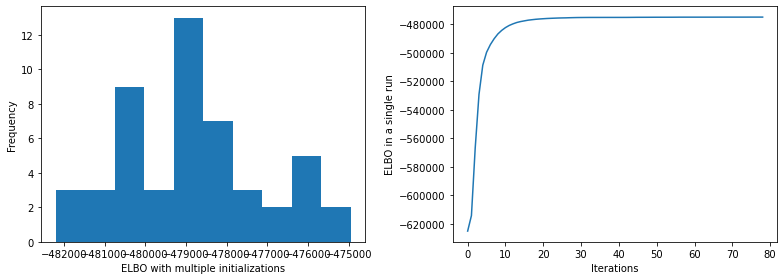

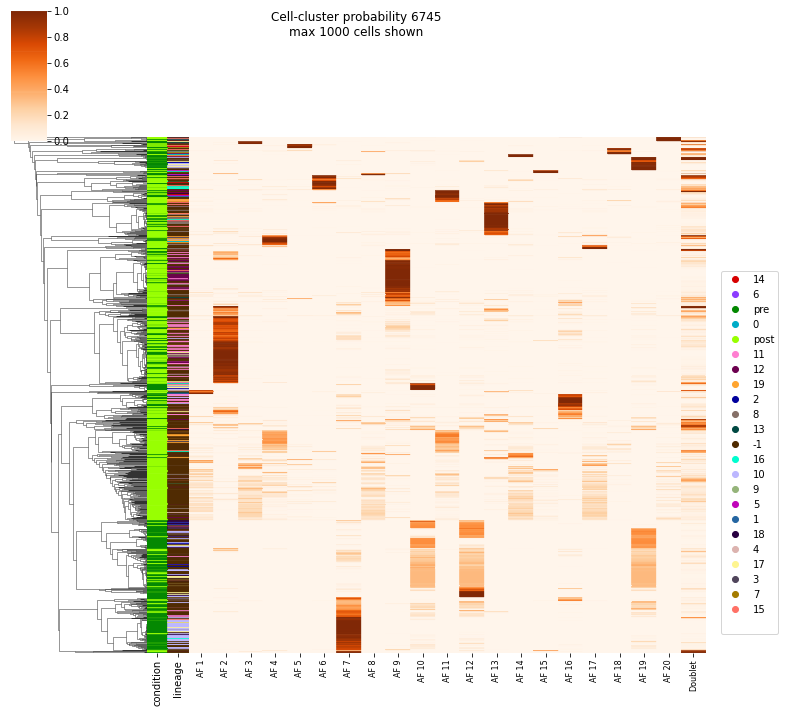

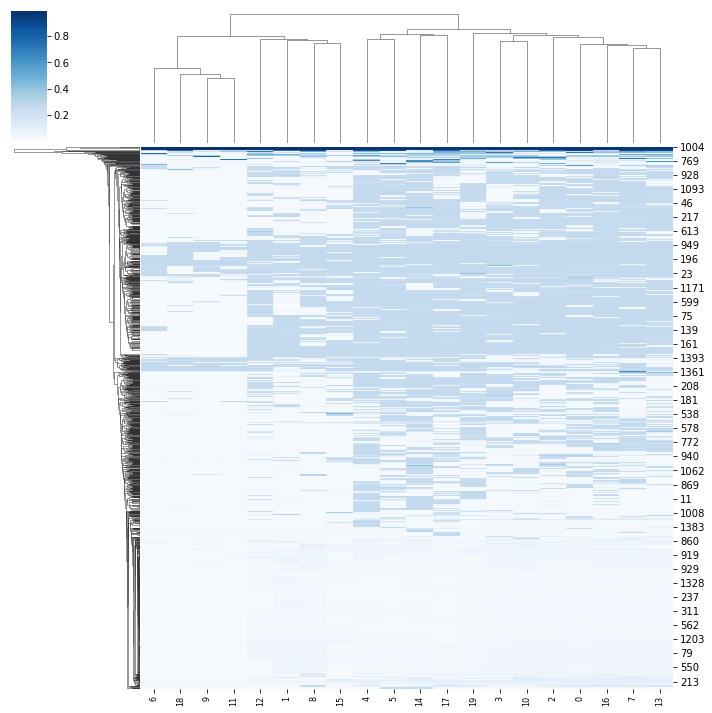

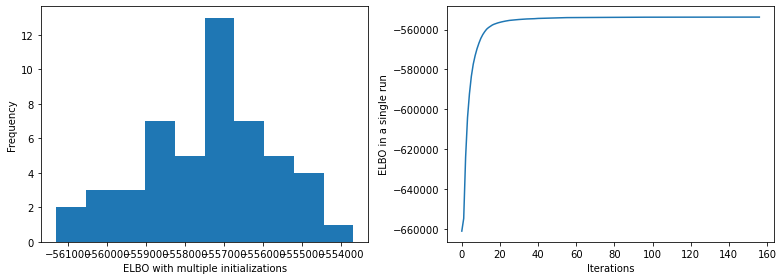

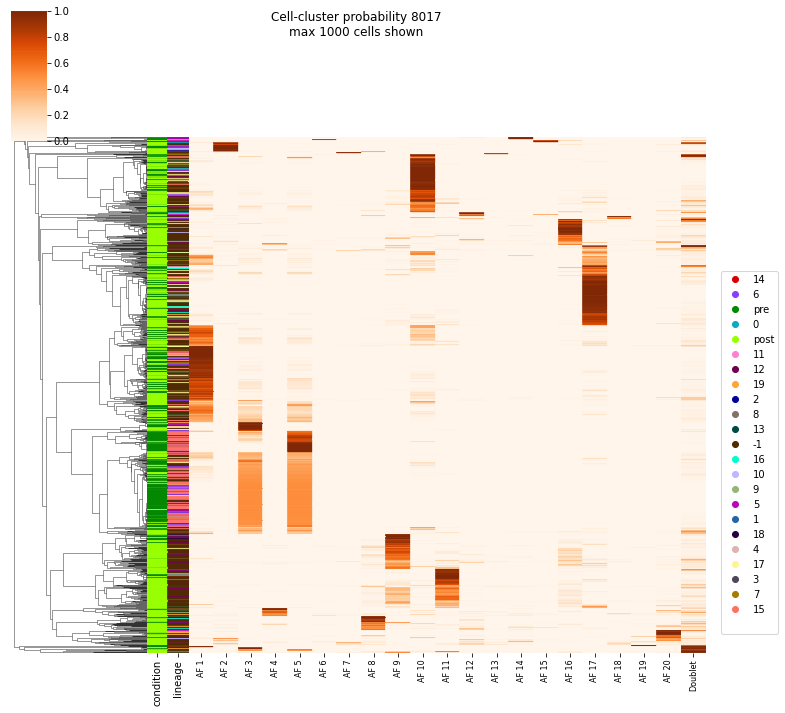

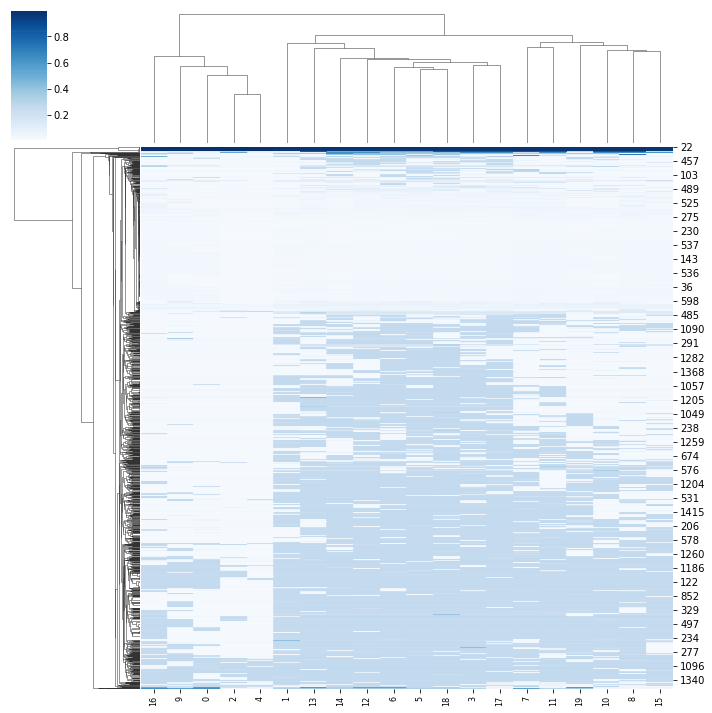

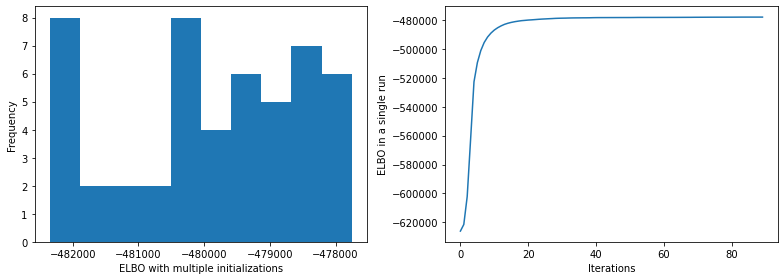

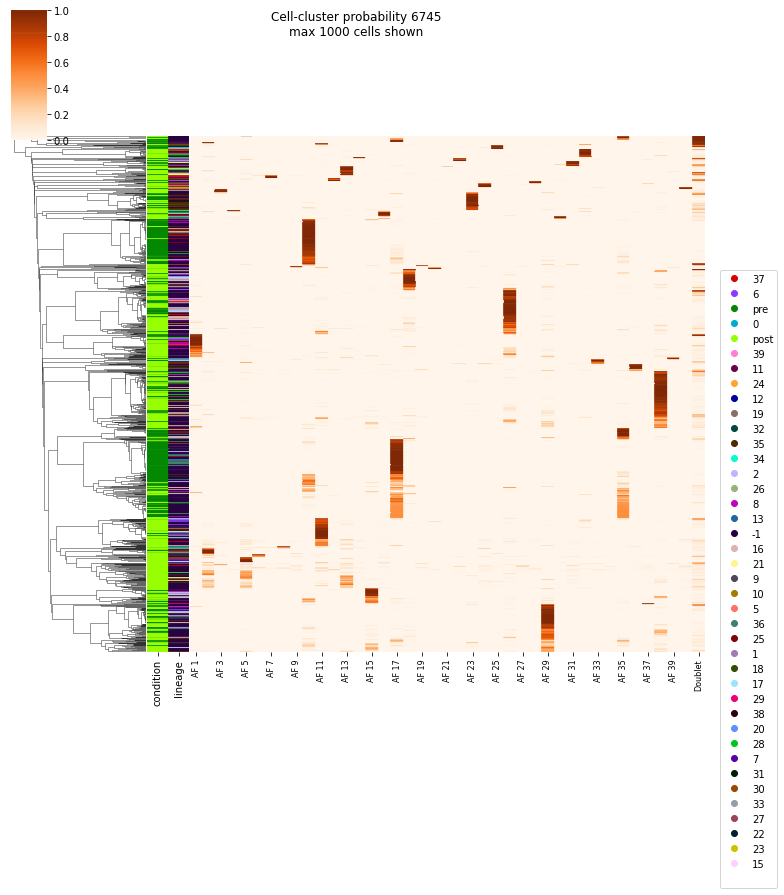

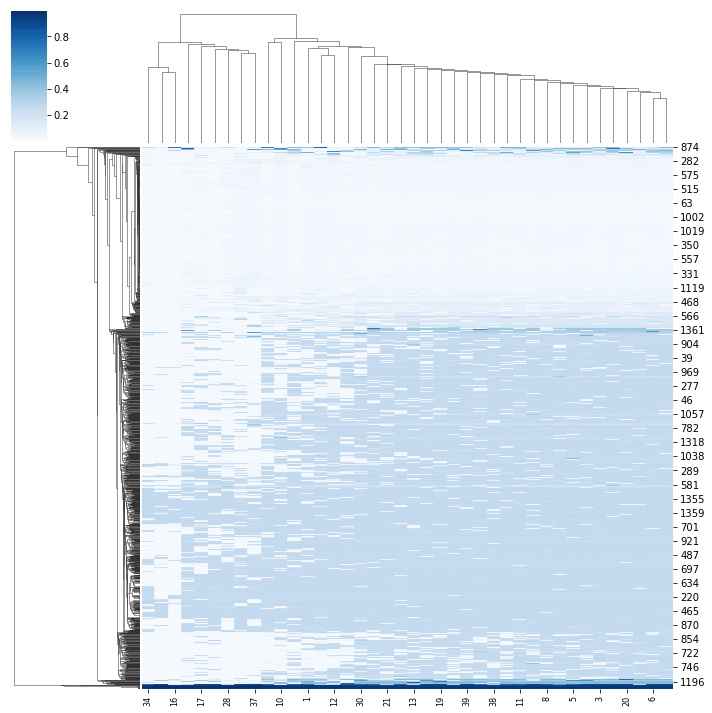

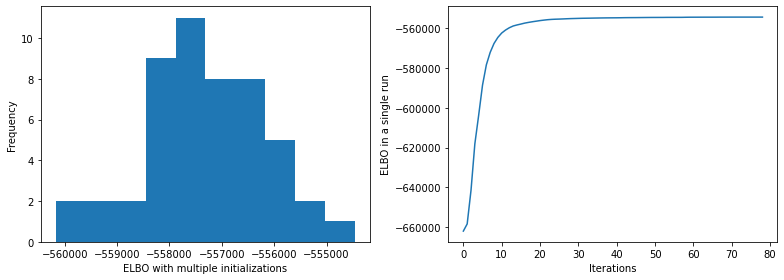

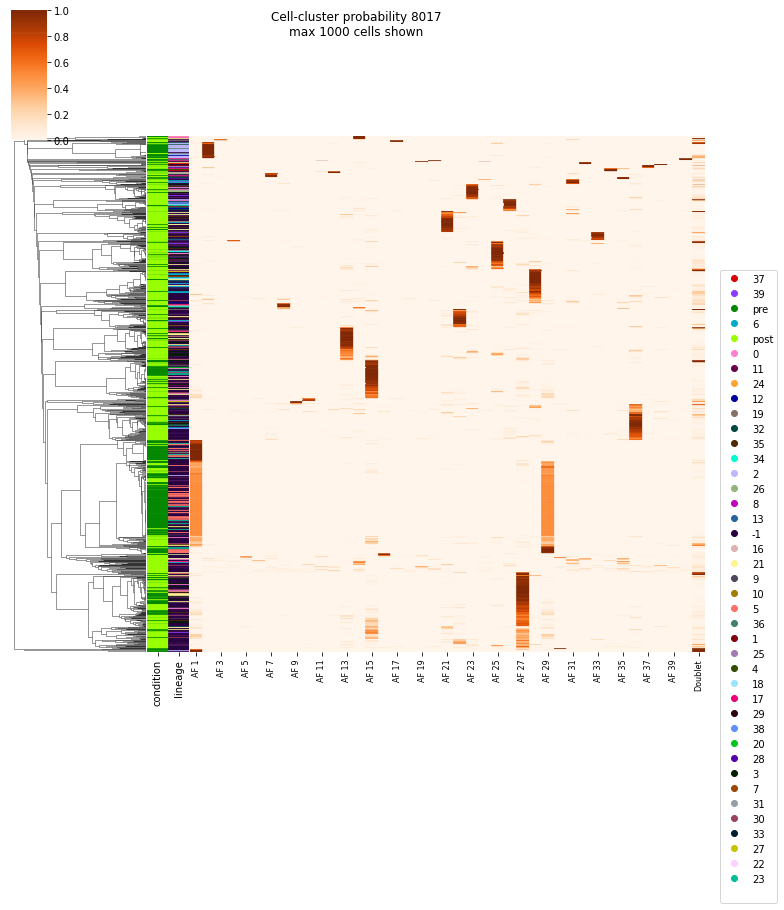

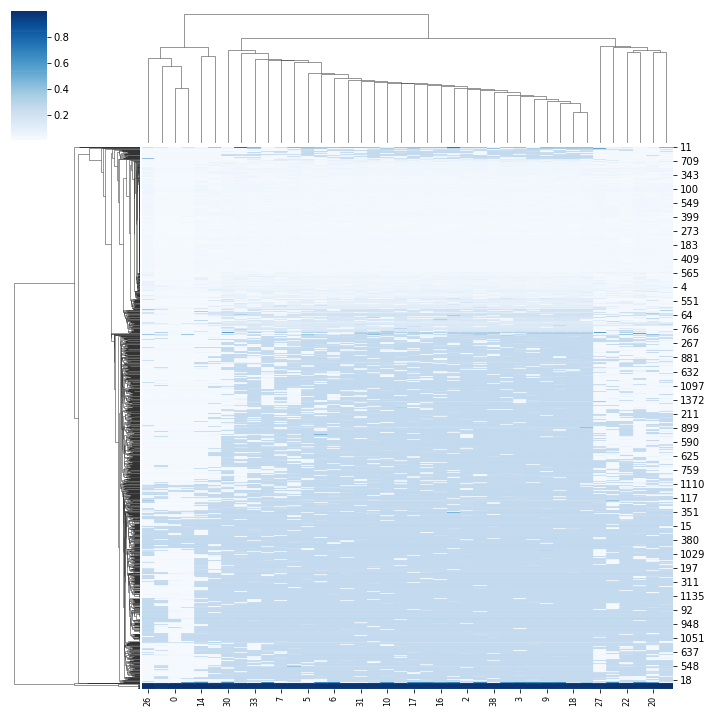

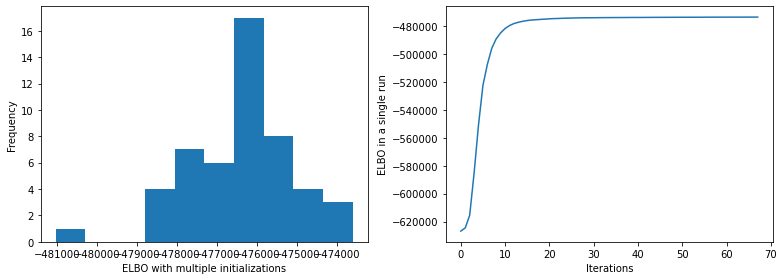

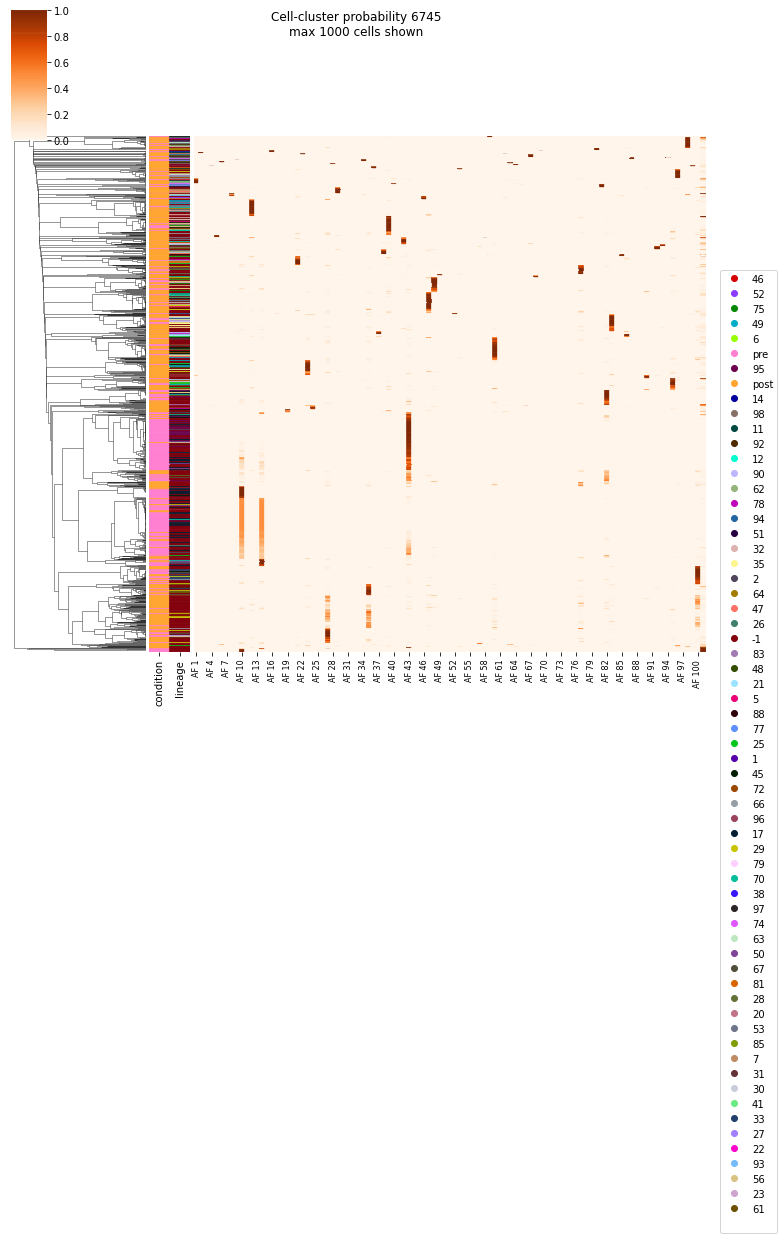

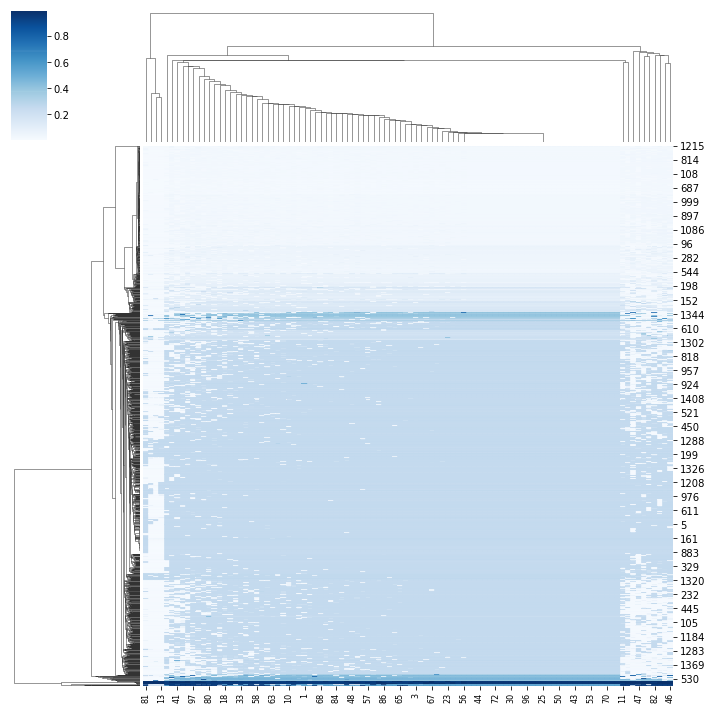

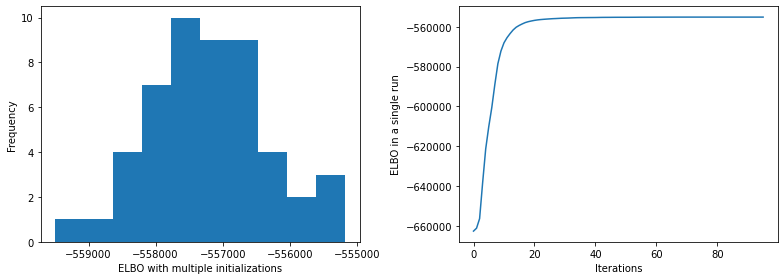

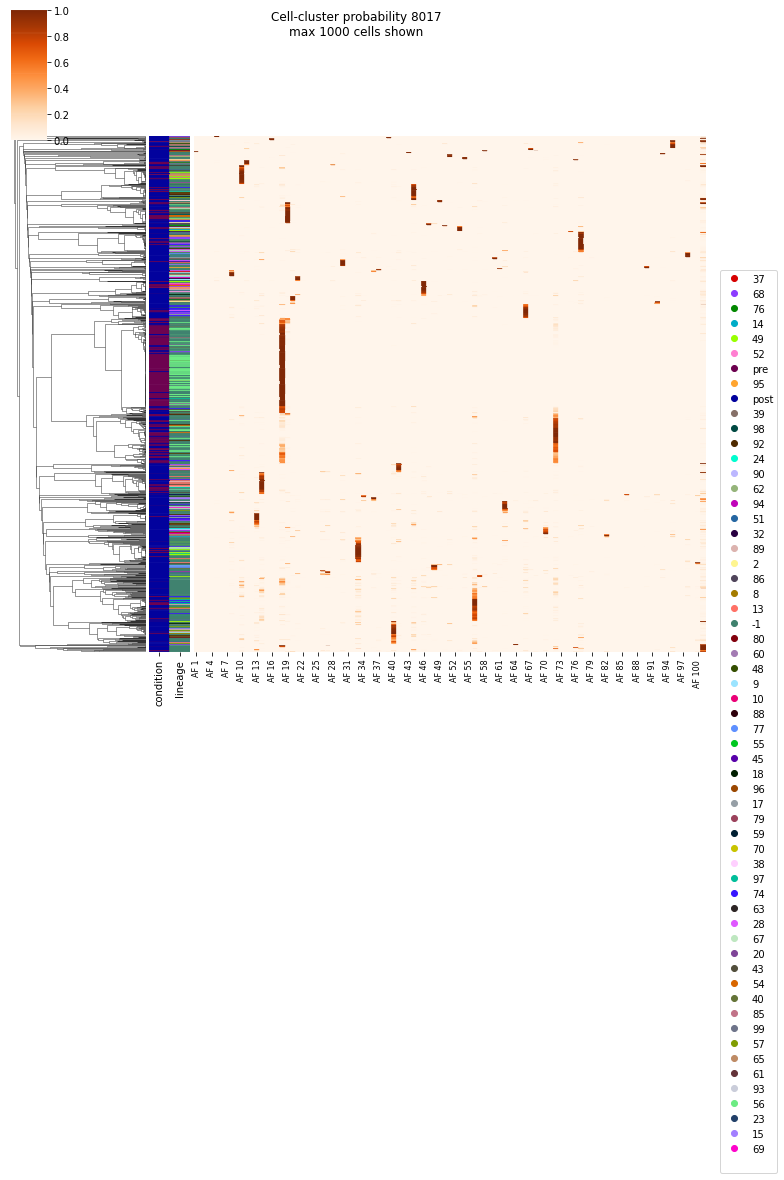

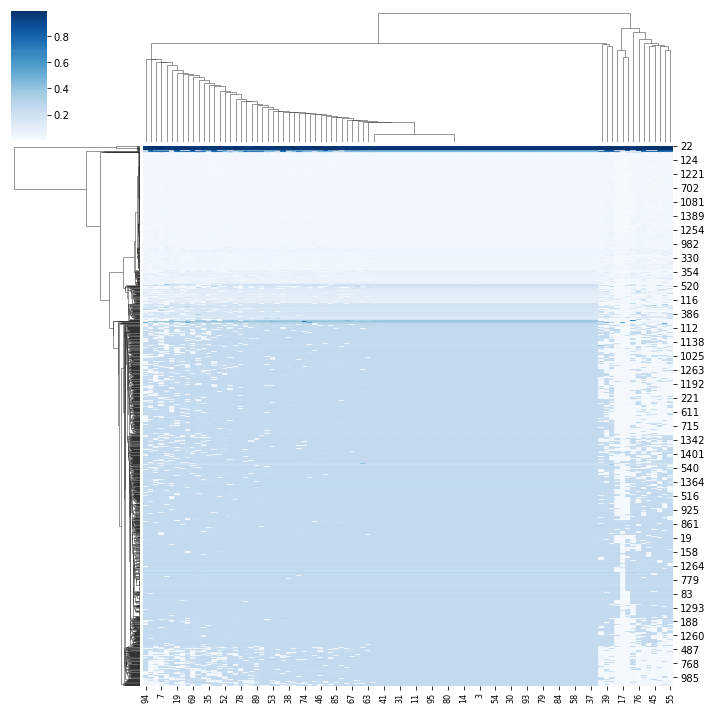

In [13]:
run_lineage_wrap(INDIR, OUTDIR, N_DONORS, n_clone_list, cells_meta)